In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from google.colab import drive
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Rakamin/HCI'

Mounted at /content/drive


In [3]:
train_data = pd.read_csv('/content/drive/My Drive/Rakamin/HCI/application_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Rakamin/HCI/application_test.csv')

In [4]:
bureau = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/bureau_balance.csv')
previous_app = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/previous_application.csv')
installments_payments = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/installments_payments.csv')
pos_cash_balance = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('/content/drive/MyDrive/Rakamin/HCI/credit_card_balance.csv')


**Mengecek missing values pada setiap dataset**


In [5]:
print(train_data.info())
print(train_data.describe())
print("Missing values in application_train:", train_data.isnull().sum().sum())
print("Missing values in application_test:", test_data.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.

**Data Celaning and Preprocessing**

In [6]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({'DAYS_CREDIT': 'min', 'CREDIT_ACTIVE': 'count', 'AMT_CREDIT_SUM': 'sum'})
bureau_agg.columns = ['DAYS_CREDIT_MIN', 'CREDIT_ACTIVE_COUNT', 'TOTAL_CREDIT_SUM']


In [7]:
previous_app_agg = previous_app.groupby('SK_ID_CURR').agg({'AMT_CREDIT': 'sum', 'NAME_CONTRACT_STATUS': 'count'})
previous_app_agg.columns = ['TOTAL_PREV_CREDIT', 'PREV_APP_COUNT']

In [8]:
train_data = train_data.merge(bureau_agg, on='SK_ID_CURR', how='left', suffixes=('', '_bureau'))
train_data = train_data.merge(previous_app_agg, on='SK_ID_CURR', how='left', suffixes=('', '_prevapp'))

test_data = test_data.merge(bureau_agg, on='SK_ID_CURR', how='left', suffixes=('', '_bureau'))
test_data = test_data.merge(previous_app_agg, on='SK_ID_CURR', how='left', suffixes=('', '_prevapp'))


In [9]:
train_data, test_data = train_data.align(test_data, join='left', axis=1)
imputer = SimpleImputer(strategy='median')
numeric_cols = train_data.select_dtypes(include=['number']).columns

train_data[numeric_cols] = imputer.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = imputer.transform(test_data[numeric_cols])


In [10]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)


In [11]:
test_data, train_data = test_data.align(train_data, join='left', axis=1)
test_data.fillna(0, inplace=True)

In [12]:
X = train_data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_data['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

**Model Logistic Regression**

In [14]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Logistic Regression Accuracy: 0.9192397118839731
Confusion Matrix:
 [[56468    86]
 [ 4881    68]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.44      0.01      0.03      4949

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



**Model Random Forest**

In [17]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=3,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

random_search.fit(X_sample, y_sample)

best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:")
print(classification_report(y_val, y_pred_rf))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Random Forest Accuracy: 0.9195323805342829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Evaluasi dengan Confusion Matrix & ROC Curve**

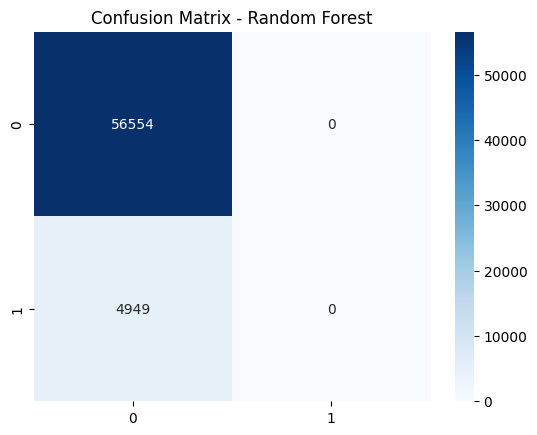

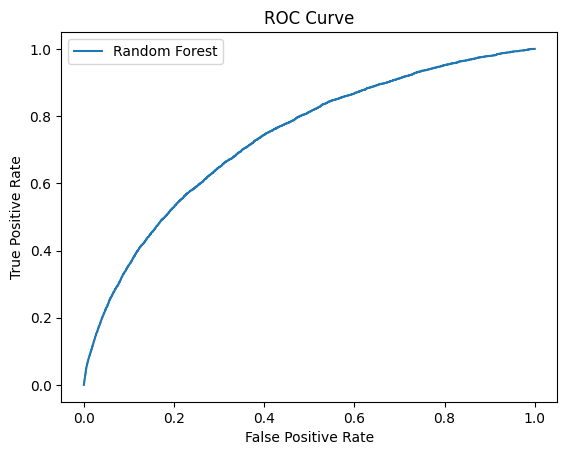

In [18]:
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

fpr, tpr, _ = roc_curve(y_val, best_rf.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Ukur Dampak Model dan Rekomendasi Bisnis**

In [19]:
auc_score = roc_auc_score(y_val, best_rf.predict_proba(X_val)[:,1])
print(f"AUC-ROC Score: {auc_score}")
if auc_score > 0.75:
    print("Model cukup baik untuk diterapkan dalam bisnis.")
else:
    print("Model masih perlu perbaikan sebelum diterapkan.")

AUC-ROC Score: 0.7357575079939941
Model masih perlu perbaikan sebelum diterapkan.


In [24]:
os.system("git init")
os.system("git add .")
os.system("git commit -m 'Initial commit'")
os.system("git branch -M main")
os.system("git remote add origin <https://github.com/anitamds/Rakamin_HCI>")
os.system("git push -u origin main")

256

In [25]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': 'min',
    'AMT_CREDIT_SUM': 'sum'
}).reset_index()
bureau_agg = bureau_agg.merge(train_data[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR')
print(bureau_agg.groupby('TARGET').mean())

           SK_ID_CURR  DAYS_CREDIT  AMT_CREDIT_SUM
TARGET                                            
0.0     278199.639150 -1781.189752    1.972495e+06
1.0     277168.494256 -1537.790848    1.756600e+06


**Insight**

Available columns: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'CO

<ipython-input-35-dd50c55564f8>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = train_data.groupby('INCOME_BRACKET')['TARGET'].agg(['mean', 'count']).reset_index()


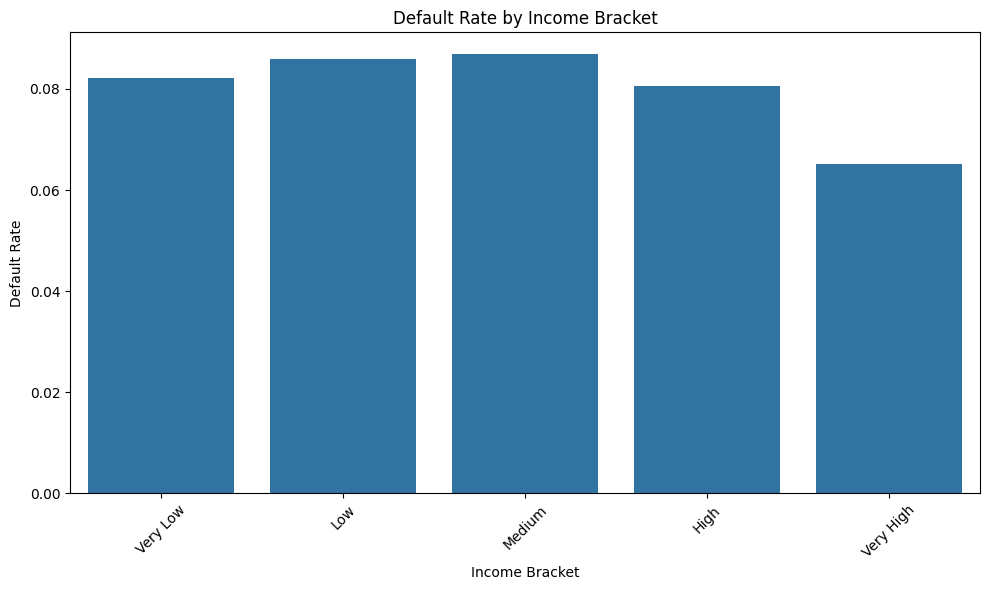

  Income Bracket  Default Rate  Count
0       Very Low      0.082062  63671
1            Low      0.085883  85756
2         Medium      0.086847  35453
3           High      0.080569  75513
4      Very High      0.065198  47118

=== Loan Amount Analysis ===


<ipython-input-35-dd50c55564f8>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_default = train_data.groupby('LOAN_BRACKET')['TARGET'].agg(['mean', 'count']).reset_index()


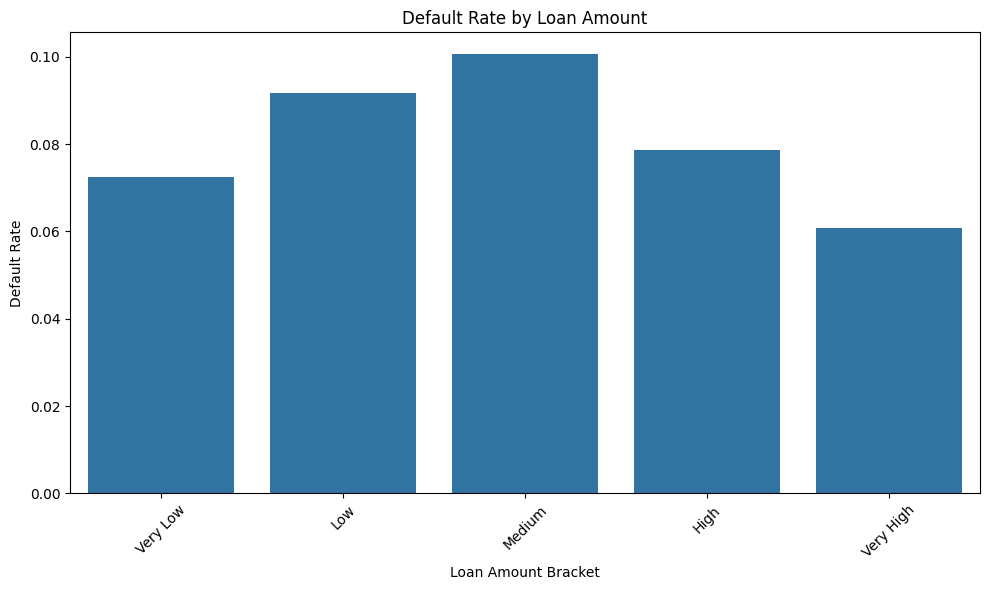

  Loan Amount Bracket  Default Rate  Count
0            Very Low      0.072376  64925
1                 Low      0.091724  58098
2              Medium      0.100549  61552
3                High      0.078549  64024
4           Very High      0.060752  58912

=== Contract Type Analysis ===


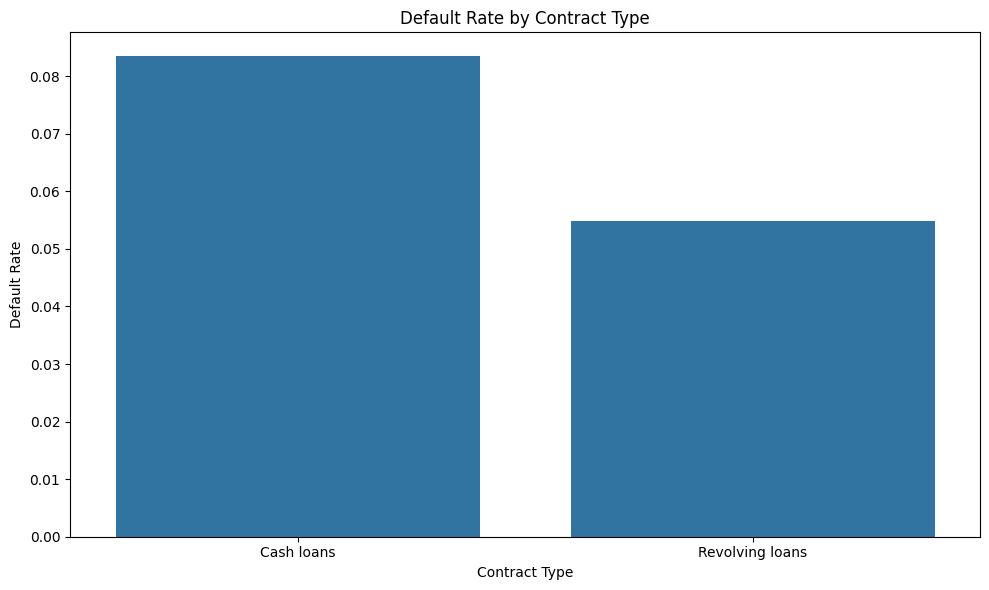

     Contract Type  Default Rate   Count  Percentage of Total
0       Cash loans      0.083459  278232            90.478715
1  Revolving loans      0.054783   29279             9.521285

=== Payment Rate Statistics ===
           count      mean       std       min       25%   50%       75%  \
TARGET                                                                     
0       282674.0  0.053610  0.022639  0.022073  0.036296  0.05  0.063900   
1        24825.0  0.054659  0.020577  0.022077  0.039656  0.05  0.066827   

             max  
TARGET            
0       0.124430  
1       0.124428  


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('/content/drive/My Drive/Rakamin/HCI/application_train.csv')

print("Available columns:", train_data.columns.tolist())

# 1. Analysis of Income vs Default Rate
def analyze_income_default():
    train_data['INCOME_BRACKET'] = pd.qcut(train_data['AMT_INCOME_TOTAL'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    income_default = train_data.groupby('INCOME_BRACKET')['TARGET'].agg(['mean', 'count']).reset_index()
    income_default.columns = ['Income Bracket', 'Default Rate', 'Count']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=income_default, x='Income Bracket', y='Default Rate')
    plt.title('Default Rate by Income Bracket')
    plt.xticks(rotation=45)
    plt.ylabel('Default Rate')
    plt.tight_layout()
    plt.show()

    return income_default

# 2. Analysis of Loan Amount vs Default
def analyze_loan_amount():
    train_data['LOAN_BRACKET'] = pd.qcut(train_data['AMT_CREDIT'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    loan_default = train_data.groupby('LOAN_BRACKET')['TARGET'].agg(['mean', 'count']).reset_index()
    loan_default.columns = ['Loan Amount Bracket', 'Default Rate', 'Count']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=loan_default, x='Loan Amount Bracket', y='Default Rate')
    plt.title('Default Rate by Loan Amount')
    plt.xticks(rotation=45)
    plt.ylabel('Default Rate')
    plt.tight_layout()
    plt.show()

    return loan_default

# 3. Analysis of Contract Type
def analyze_contract_type():
    if 'NAME_CONTRACT_TYPE' in train_data.columns:
        contract_default = train_data.groupby('NAME_CONTRACT_TYPE')['TARGET'].agg(['mean', 'count']).reset_index()
        contract_default.columns = ['Contract Type', 'Default Rate', 'Count']
        contract_default['Percentage of Total'] = contract_default['Count'] / len(train_data) * 100

        plt.figure(figsize=(10, 6))
        sns.barplot(data=contract_default, x='Contract Type', y='Default Rate')
        plt.title('Default Rate by Contract Type')
        plt.ylabel('Default Rate')
        plt.tight_layout()
        plt.show()

        return contract_default
    else:
        print("Contract type column not found in dataset")
        return None

print("\n=== Income Analysis ===")
income_results = analyze_income_default()
print(income_results)

print("\n=== Loan Amount Analysis ===")
loan_results = analyze_loan_amount()
print(loan_results)

print("\n=== Contract Type Analysis ===")
contract_results = analyze_contract_type()
if contract_results is not None:
    print(contract_results)

train_data['PAYMENT_RATE'] = train_data['AMT_ANNUITY'] / train_data['AMT_CREDIT']
print("\n=== Payment Rate Statistics ===")
payment_stats = train_data.groupby('TARGET')['PAYMENT_RATE'].describe()
print(payment_stats)